In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import  ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langsmith import traceable
from langsmith import Client


import requests
import random
import os

In [2]:
load_dotenv(override=True)

True

In [3]:
# 1. LLM
llm = ChatOpenAI()

In [4]:
# 2. Tools
# -------------------
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}
    



ALPHA_API_KEY = os.getenv("ALPHA_VINTAGE_API_KEY")

@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={ALPHA_API_KEY}"
    r = requests.get(url)
    return r.json()



In [5]:
# Make tool list
tools = [search_tool, get_stock_price, calculator]

# Make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [6]:
# 3. State
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [7]:
# 4. Nodes
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)

In [8]:
# 5. Checkpointer
conn = sqlite3.connect(database="chatbot2.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

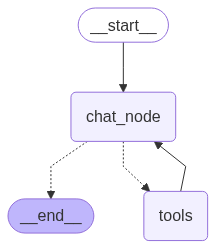

In [9]:
# 6. Graph
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")

graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile(checkpointer=checkpointer)
chatbot

In [10]:
CONFIG = {'configurable': {'thread_id': 'thread_1'}}
out = chatbot.invoke({"messages": [HumanMessage(content="Hello!")]}, config=CONFIG)
print(out["messages"])
print(out["messages"][-1].content)

[HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='160d2fd5-6dac-48c2-88b3-33f938acf492'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 172, 'total_tokens': 182, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9WO8mXH3i42jrXDA9obUTkkFWnXQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f9c3f758-9a6d-4310-9548-620d7e87fc95-0', usage_metadata={'input_tokens': 172, 'output_tokens': 10, 'total_tokens': 182, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Hello!', additional_kwargs={}, res

In [11]:
CONFIG = {'configurable': {'thread_id': 'thread_1'}}
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3")]}, config=CONFIG)
print(out["messages"])
print(out["messages"][-1].content)

[HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='160d2fd5-6dac-48c2-88b3-33f938acf492'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 172, 'total_tokens': 182, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9WO8mXH3i42jrXDA9obUTkkFWnXQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f9c3f758-9a6d-4310-9548-620d7e87fc95-0', usage_metadata={'input_tokens': 172, 'output_tokens': 10, 'total_tokens': 182, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Hello!', additional_kwargs={}, res

In [12]:
CONFIG = {'configurable': {'thread_id': 'thread_1'}}
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of Apple")]}, config=CONFIG)
print(out["messages"])
print(out["messages"][-1].content)

[HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='160d2fd5-6dac-48c2-88b3-33f938acf492'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 172, 'total_tokens': 182, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9WO8mXH3i42jrXDA9obUTkkFWnXQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f9c3f758-9a6d-4310-9548-620d7e87fc95-0', usage_metadata={'input_tokens': 172, 'output_tokens': 10, 'total_tokens': 182, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Hello!', additional_kwargs={}, res

In [13]:
CONFIG = {'configurable': {'thread_id': 'thread_1'}}
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of Apple. How much it cost to purchase 50 shares?")]}, config=CONFIG)
print(out["messages"])
print(out["messages"][-1].content)

[HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='160d2fd5-6dac-48c2-88b3-33f938acf492'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 172, 'total_tokens': 182, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9WO8mXH3i42jrXDA9obUTkkFWnXQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f9c3f758-9a6d-4310-9548-620d7e87fc95-0', usage_metadata={'input_tokens': 172, 'output_tokens': 10, 'total_tokens': 182, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Hello!', additional_kwargs={}, res